In [1]:
#for pandas
import pandas as pd

In [2]:
#for numpy
import numpy as np

In [3]:
#for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#from scikit library 
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import f1_score,log_loss

In [5]:
def sol_to_submit(data,result,filename):
    filename=filename+".csv"
    sub=np.hstack((np.array(data.iloc[:,0]).reshape(-1,1),np.array(result).reshape(-1,1)))
    np.savetxt(filename,sub,header="PassengerId,Survived",delimiter=',')

In [6]:
#scale self features and return mean and variance
def feature_scale_own(x):
    m=x.shape[0]
    mu=(1/m)*np.sum(x,axis=0)
    sig=np.std(x,axis=0,ddof=1)
    mu[0]=0
    sig[0]=1
    x=(x-mu)/sig
    return x,mu,sig

In [7]:
#scale itself using mean and variance of some other set
def feature_scale_other(x,mu,sig):
    x=(x-mu)/sig
    return x

In [8]:
#computing sigmoid function
def gz(theta,x):
    hey=x.dot(theta)
    hey=1+np.exp((-1)*hey)
    hey=1/hey
    return hey

In [9]:
#computes gradient at particular point
def compute_grad(theta,x,y,lambo=0):
    hey=gz(theta,x)
    m=x.shape[0]
    grad=(1/m)*(np.transpose(x).dot(hey-y))
    grad[1:]=grad[1:]+(lambo/m)*(theta[1:])
    return grad

In [10]:
def classi(spy,ep=0.5):
    return ((spy>ep).astype(int))

In [11]:
def prediction_test(data,theta,ep,mu,sig,deg_opt,listu):
    listu=np.array(listu)-1
    x_=np.array(data.iloc[:,listu])
    poly=PolynomialFeatures(degree=deg_opt,include_bias=True,interaction_only=False)
    x=poly.fit_transform(x_)
    x=(x-mu)/sig
    hey=classi(gz(theta,x),ep)
    return hey

In [12]:
def impute_own(data):
    
    #first processing Age column
    hey=data["Age"].notnull().ravel()
    notnull_index=[]
    isnull_index=[]
    for i in range(0,len(hey)):
        if hey[i]==True:
          notnull_index.append(i)
        else:
          isnull_index.append(i)
    venom=data.iloc[notnull_index,5]
    mean_age=(1/len(notnull_index))*(venom.sum())
    data.iloc[isnull_index,5]=mean_age
    
    #now dealing with sex column
    #as it has no null values so we just replace male by 0 and female by 1
    data.iloc[(data["Sex"]=="male").ravel(),4]=0
    data.iloc[(data["Sex"]=="female").ravel(),4]=1
    
    #now dealing with Embarked column
    #now we deal with null values and then we just replace by 0,1,-1
    spydy=data["Embarked"].value_counts()
    ind=np.argmax(np.array(spydy))
    rownames=spydy.index
    most_embark=rownames[ind]
    
    data.iloc[(data["Embarked"]).isnull().ravel(),11]=most_embark
    
    data.iloc[(data["Embarked"]=='Q').ravel(),11]=-1
    data.iloc[(data["Embarked"]=='C').ravel(),11]=0
    data.iloc[(data["Embarked"]=='S').ravel(),11]=1
    
    #dealing with missing fare in test set
    fare_avg=(1/data.shape[0])*(data["Fare"].sum())
    
    #converting columns to float
    data["Survived"]=data["Survived"].astype(float)
    data["Pclass"]=data["Pclass"].astype(float)
    data["Sex"]=data["Sex"].astype(float)
    data["Age"]=data["Age"].astype(float)
    data["SibSp"]=data["SibSp"].astype(float)
    data["Parch"]=data["Parch"].astype(float)
    data["Fare"]=data["Fare"].astype(float)
    data["Embarked"]=data["Embarked"].astype(float)

    
    return data,mean_age,most_embark,fare_avg

In [13]:
def impute_other(data,meany,embarky,fare_avg,istest=False):
    if istest==True:
        minus=1
    else:
        minus=0
    #first processing Age column
    hey=data["Age"].notnull().ravel()
    isnull_index=[]
    for i in range(0,len(hey)):
        if hey[i]==False:
          isnull_index.append(i)
    data.iloc[isnull_index,5-minus]=meany
    
    #now dealing with sex column
    #as it has no null values so we just replace male by 0 and female by 1
    data.iloc[(data["Sex"]=="male").ravel(),4-minus]=0
    data.iloc[(data["Sex"]=="female").ravel(),4-minus]=1
    
    #now dealing with Embarked column
    
    data.iloc[(data["Embarked"]).isnull().ravel(),11-minus]=embarky
    
    data.iloc[(data["Embarked"]=='Q').ravel(),11-minus]=-1
    data.iloc[(data["Embarked"]=='C').ravel(),11-minus]=0
    data.iloc[(data["Embarked"]=='S').ravel(),11-minus]=1
    
    #dealing with missing fare in test set
    check=data["Fare"].isnull().sum()
    if check!=0:
        miss=data["Fare"].index[data["Fare"].apply(np.isnan)]
        for i in miss:
            data.iloc[i,9-minus]=fare_avg
    
    #converting columns to float
    if istest==False:
      data["Survived"]=data["Survived"].astype(float)
    
    data["Pclass"]=data["Pclass"].astype(float)
    data["Sex"]=data["Sex"].astype(float)
    data["Age"]=data["Age"].astype(float)
    data["SibSp"]=data["SibSp"].astype(float)
    data["Parch"]=data["Parch"].astype(float)
    data["Fare"]=data["Fare"].astype(float)
    data["Embarked"]=data["Embarked"].astype(float)
    
    return data

In [14]:
dfl="C:/Users/Ritik/Desktop/Projects_Flash/Titanic_/train.csv"

In [15]:
datatrain=pd.read_csv(dfl,header=0)

In [16]:
datatrain.sum()

PassengerId                                               397386
Survived                                                     342
Pclass                                                      2057
Name           Braund, Mr. Owen HarrisCumings, Mrs. John Brad...
Sex            malefemalefemalefemalemalemalemalemalefemalefe...
Age                                                      21205.2
SibSp                                                        466
Parch                                                        340
Ticket         A/5 21171PC 17599STON/O2. 31012821138033734503...
Fare                                                     28693.9
dtype: object

In [17]:
datatrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
datatrain.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


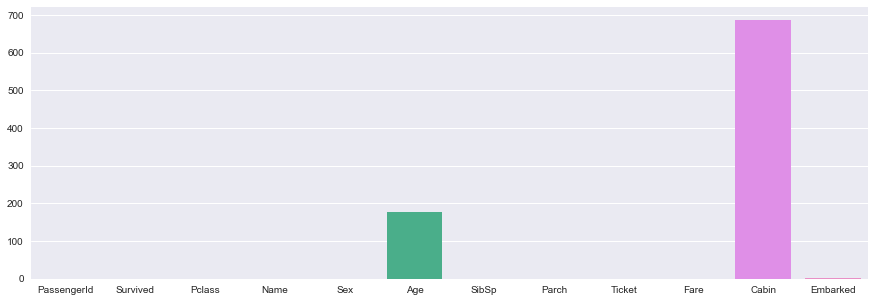

In [19]:
colnames=datatrain.columns.values
misscount=[datatrain[x].isnull().sum() for x in colnames]
sns.set()
plt.figure(figsize=(15,5))
sns.barplot(colnames,misscount)

In [20]:
datatrain.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [21]:
datatrain.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [22]:
colnames=datatrain.columns.values
for i in range(0,len(colnames)):
    print("%d   %s"%(i,colnames[i]))

0   PassengerId
1   Survived
2   Pclass
3   Name
4   Sex
5   Age
6   SibSp
7   Parch
8   Ticket
9   Fare
10   Cabin
11   Embarked


So, 
- Age column has 177 null values
- Cabin has 687 null values
- Embarked has 2 null values
- Convert Embarked column to some numeric type
- Convert Sex column to some numeric type
- convert every nueric column in use to float type

In [23]:
listy=[2,4,5,6,7,9,11]
skf=StratifiedKFold(n_splits=9)

### In this we will use linear model with mean replacement , just a trial run

In [24]:
iterations=500
alpha=0.1
ite=np.arange(0,iterations+1,1)
J_val_val=np.zeros(iterations+1)
J_val_train=np.zeros(iterations+1)
theta_one=np.zeros(datatrain.iloc[:,listy].shape[1]+1).reshape(-1,1)


for train_index,val_index in skf.split(np.array(datatrain),np.zeros(datatrain.shape[0])):
    transportone=datatrain.loc[train_index,:].copy()
    transporttwo=datatrain.loc[val_index,:].copy()
    data_rough,mean_age,most_embark,fare_avg=impute_own(transportone)
    data_murph=impute_other(transporttwo,mean_age,most_embark,fare_avg)
    
    xt=np.array(data_rough.iloc[:,listy])
    yt=np.array(data_rough.iloc[:,1]).reshape(-1,1)
    xv=np.array(data_murph.iloc[:,listy])
    yv=np.array(data_murph.iloc[:,1]).reshape(-1,1)
    #now adding bias columns to training and validation sets
    xv=np.hstack((np.ones(xv.shape[0]).reshape(-1,1),xv))
    xt=np.hstack((np.ones(xt.shape[0]).reshape(-1,1),xt))
    #now normalizing
    xt,mu,sig=feature_scale_own(xt)
    xv=feature_scale_other(xv,mu,sig)
    
    theta_rough=np.zeros(xt.shape[1]).reshape(-1,1)
    
    #J_val before 1st iterations
    J_val_val[0]=J_val_val[0]+log_loss(yv,gz(theta_rough,xv))
    J_val_train[0]=J_val_train[0]+log_loss(yt,gz(theta_rough,xt))
    for i in range(1,iterations+1):
        theta_rough=theta_rough-alpha*(compute_grad(theta_rough,xt,yt))
        J_val_train[i]=J_val_train[i]+log_loss(yt,gz(theta_rough,xt))
        J_val_val[i]=J_val_val[i]+log_loss(yv,gz(theta_rough,xv))
    theta_one=np.hstack((theta_one,theta_rough))

In [25]:
J_val_val=(1/9)*J_val_val
J_val_train=(1/9)*J_val_train
theta_one=(1/9)*np.sum(theta_one,axis=1)
print(theta_one)

[-0.63731406 -0.89293174  1.28643305 -0.49916888 -0.35754764 -0.07926659
  0.14779553 -0.15635198]


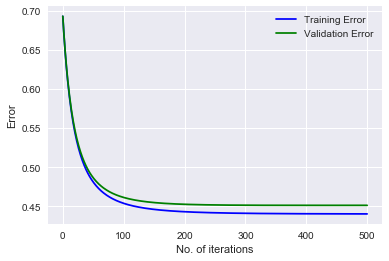

In [26]:
plt.plot(ite,J_val_train,c='blue')
plt.plot(ite,J_val_val,c='green')
plt.xlabel("No. of iterations")
plt.ylabel("Error")
plt.legend(["Training Error","Validation Error"])

In [27]:
datatrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now we will plot learning curve with respect to number of training examples

In [28]:
iterations=500
alpha=0.1
mset=np.arange(1,793,1)       #each set size->891/9=99 ,,  training set size-> 99*8=792
J_m_val=np.zeros(len(mset))
J_m_train=np.zeros(len(mset))

for train_index,val_index in skf.split(np.array(datatrain),np.zeros(datatrain.shape[0])):
    transportone=datatrain.loc[train_index,:].copy()
    transporttwo=datatrain.loc[val_index,:].copy()
    data_rough,mean_age,most_embark,fare_avg=impute_own(transportone)
    data_murph=impute_other(transporttwo,mean_age,most_embark,fare_avg)
    
    xt=np.array(data_rough.iloc[:,listy])
    yt=np.array(data_rough.iloc[:,1]).reshape(-1,1)
    xv=np.array(data_murph.iloc[:,listy])
    yv=np.array(data_murph.iloc[:,1]).reshape(-1,1)
    #now adding bias columns to training and validation sets
    xv=np.hstack((np.ones(xv.shape[0]).reshape(-1,1),xv))
    xt=np.hstack((np.ones(xt.shape[0]).reshape(-1,1),xt))
    #now normalizing
    xt,mu,sig=feature_scale_own(xt)
    xv=feature_scale_other(xv,mu,sig)
    
    theta_rough=np.zeros(xt.shape[1]).reshape(-1,1)
    
    for m in mset:
        theta_rough=np.zeros(xt.shape[1]).reshape(-1,1)
        for i in range(1,iterations+1):
          theta_rough=theta_rough-alpha*(compute_grad(theta_rough,xt[0:m,:],yt[0:m]))
        J_m_train[m-1]=J_m_train[m-1]+log_loss(yt[0:m],gz(theta_rough,xt[0:m,:]),labels=[0,1])
        J_m_val[m-1]=J_m_val[m-1]+log_loss(yv,gz(theta_rough,xv))

In [29]:
J_m_val=(1/9)*J_m_val
J_m_train=(1/9)*J_m_train

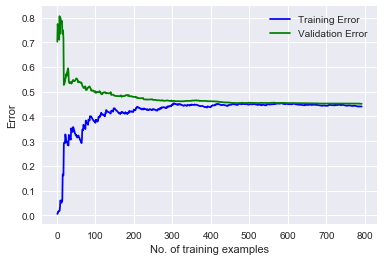

In [30]:
plt.plot(mset,J_m_train,c='blue')
plt.plot(mset,J_m_val,c='g')
plt.xlabel("No. of training examples")
plt.ylabel("Error")
plt.legend(["Training Error","Validation Error"])

In [31]:
datatrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Now we can clearly see this is a problem of high bias or say underfitting
#### So we should now try polynomial terms as well

In [32]:
iterations=1000
alpha=0.001
degset=[1,2,3,4,5,6,7]
J_deg_val=np.zeros(len(degset))
J_deg_train=np.zeros(len(degset))

for train_index,val_index in skf.split(np.array(datatrain),np.zeros(datatrain.shape[0])):
    transportone=datatrain.loc[train_index,:].copy()
    transporttwo=datatrain.loc[val_index,:].copy()
    data_rough,mean_age,most_embark,fare_avg=impute_own(transportone)
    data_murph=impute_other(transporttwo,mean_age,most_embark,fare_avg)
    
    xt_=np.array(data_rough.iloc[:,listy])
    yt=np.array(data_rough.iloc[:,1]).reshape(-1,1)
    xv_=np.array(data_murph.iloc[:,listy])
    yv=np.array(data_murph.iloc[:,1]).reshape(-1,1)
    #now polynomial features
    
    for degri in degset:
      poly=PolynomialFeatures(degree=degri,include_bias=True,interaction_only=False)
      xv=poly.fit_transform(xv_)
      xt=poly.fit_transform(xt_)
      #now normalizing
      xt,mu,sig=feature_scale_own(xt)
      xv=feature_scale_other(xv,mu,sig)
      theta_rough=np.zeros(xt.shape[1]).reshape(-1,1)   
      for i in range(1,iterations+1):
        theta_rough=theta_rough-alpha*(compute_grad(theta_rough,xt,yt))
      J_deg_val[degri-1]=J_deg_val[degri-1]+log_loss(yv,gz(theta_rough,xv))
      J_deg_train[degri-1]=J_deg_train[degri-1]+log_loss(yt,gz(theta_rough,xt))
    

In [33]:
J_deg_val=(1/9)*J_deg_val
J_deg_train=(1/9)*J_deg_train

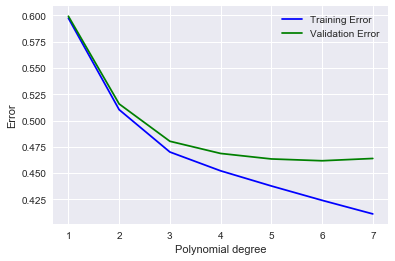

In [34]:
plt.plot(degset,J_deg_train,c='blue')
plt.plot(degset,J_deg_val,c='green')
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.legend(["Training Error","Validation Error"])

In [35]:
deg_opt=degset[np.argmin(J_deg_val)]
print(deg_opt)

6


In [36]:
datatrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now lets select degree=deg_opt and plot various values of regularization parameter

In [37]:
iterations=1000
alpha=0.1
lambdaset=np.linspace(80,200,10)
J_lam_val=np.zeros(len(lambdaset))
J_lam_train=np.zeros(len(lambdaset))
poly=PolynomialFeatures(degree=deg_opt,include_bias=True,interaction_only=False)

for train_index,val_index in skf.split(np.array(datatrain),np.zeros(datatrain.shape[0])):
    transportone=datatrain.loc[train_index,:].copy()
    transporttwo=datatrain.loc[val_index,:].copy()
    data_rough,mean_age,most_embark,fare_avg=impute_own(transportone)
    data_murph=impute_other(transporttwo,mean_age,most_embark,fare_avg)
    xt_=np.array(data_rough.iloc[:,listy])
    yt=np.array(data_rough.iloc[:,1]).reshape(-1,1)
    xv_=np.array(data_murph.iloc[:,listy])
    yv=np.array(data_murph.iloc[:,1]).reshape(-1,1)
    #now converting to degree=4
    xt=poly.fit_transform(xt_)
    xv=poly.fit_transform(xv_)
    #now normalizing
    xt,mu,sig=feature_scale_own(xt)
    xv=feature_scale_other(xv,mu,sig)
    for lam in range(0,len(lambdaset)):
        theta_rough=np.zeros(xt.shape[1]).reshape(-1,1)
        for i in range(1,iterations+1):
          theta_rough=theta_rough-alpha*(compute_grad(theta_rough,xt,yt,lambdaset[lam]))
        J_lam_val[lam]=J_lam_val[lam]+log_loss(yv,gz(theta_rough,xv))
        J_lam_train[lam]=J_lam_train[lam]+log_loss(yt,gz(theta_rough,xt))

In [38]:
J_lam_val=(1/9)*J_lam_val
J_lam_train=(1/9)*J_lam_train

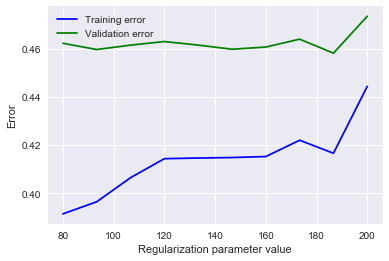

In [39]:
plt.plot(lambdaset,J_lam_train,c='b')
plt.plot(lambdaset,J_lam_val,c='g')
plt.xlabel("Regularization parameter value")
plt.ylabel("Error")
plt.legend(["Training error","Validation error"])

In [40]:
lam_opt=lambdaset[np.argmin(J_lam_val)]
print(lam_opt)

186.666666667


In [41]:
datatrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now choosing cut off value or threshhold value of logistic classifier

In [42]:
iterations=1000
alpha=0.1
epsilonset=np.linspace(0.2,0.9,50)
f1scoreset=np.zeros(len(epsilonset))
poly=PolynomialFeatures(degree=deg_opt,include_bias=True,interaction_only=False)

for train_index,val_index in skf.split(np.array(datatrain),np.zeros(datatrain.shape[0])):
    transportone=datatrain.loc[train_index,:].copy()
    transporttwo=datatrain.loc[val_index,:].copy()
    data_rough,mean_age,most_embark,fare_avg=impute_own(transportone)
    data_murph=impute_other(transporttwo,mean_age,most_embark,fare_avg)
    xt_=np.array(data_rough.iloc[:,listy])
    yt=np.array(data_rough.iloc[:,1]).reshape(-1,1)
    xv_=np.array(data_murph.iloc[:,listy])
    yv=np.array(data_murph.iloc[:,1]).reshape(-1,1)
    #now converting to degree=6
    xt=poly.fit_transform(xt_)
    xv=poly.fit_transform(xv_)
    #now normalizing
    xt,mu,sig=feature_scale_own(xt)
    xv=feature_scale_other(xv,mu,sig)
    for ep in range(0,len(epsilonset)):
      theta_rough=np.zeros(xt.shape[1]).reshape(-1,1)
      for i in range(1,iterations+1):
        theta_rough=theta_rough-alpha*(compute_grad(theta_rough,xt,yt,lam_opt))
      hey=classi(gz(theta_rough,xv),epsilonset[ep])
      f1scoreset[ep]=f1scoreset[ep]+f1_score(yv,hey)

Text(0.5,0,'Cut-off / threshold values')

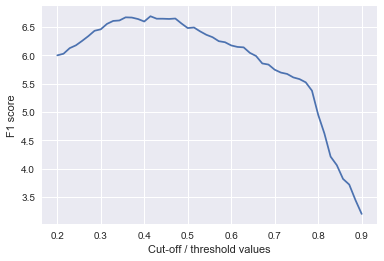

In [43]:
plt.plot(epsilonset,f1scoreset)
plt.ylabel("F1 score")
plt.xlabel("Cut-off / threshold values")

In [44]:
epsilon_opt=epsilonset[np.argmax(f1scoreset)]
print(epsilon_opt)

0.414285714286


In [45]:
datatrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now training model on full training set with above selected values of degree of polynomial , regularization parameter
and threshold value

In [47]:
iterations=2000
alpha=0.01
poly=PolynomialFeatures(degree=deg_opt,include_bias=True,interaction_only=False)
#extracting full data from datatrain
trans=datatrain.copy()
data_rough,mean_age,most_embark,fare_avg=impute_own(trans)
xt_=np.array(data_rough.iloc[:,listy])
yt=np.array(data_rough.iloc[:,1]).reshape(-1,1)
#now converting to degree
xt=poly.fit_transform(xt_)
#now normalizing
xt,mu_final,sig_final=feature_scale_own(xt)
theta_final=np.zeros(xt.shape[1]).reshape(-1,1)
for i in range(1,iterations+1):
  theta_final=theta_final-alpha*(compute_grad(theta_final,xt,yt,lam_opt))
      

In [48]:
datatrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [49]:
dfl="C:/Users/Ritik/Desktop/Projects_Flash/Titanic_/test.csv"

In [50]:
datatest=pd.read_csv(dfl,header=0)

In [51]:
datatest.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<Container object of 11 artists>

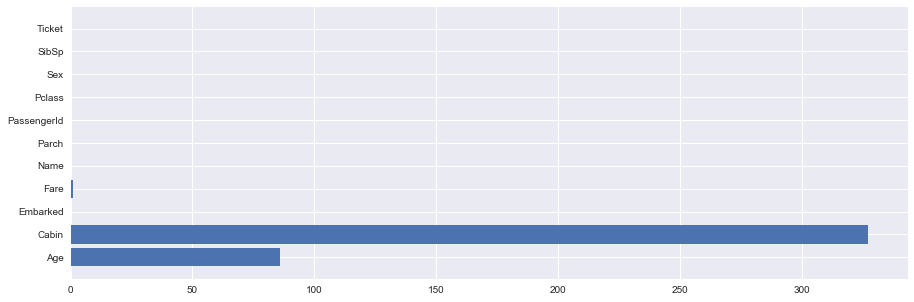

In [52]:
plt.figure(figsize=(15,5))
plt.barh(datatest.columns.values,datatest.isnull().sum())

In [53]:
colnames=datatest.columns.values
for i in range(0,len(colnames)):
    print("%d    %s"%(i,colnames[i]))

0    PassengerId
1    Pclass
2    Name
3    Sex
4    Age
5    SibSp
6    Parch
7    Ticket
8    Fare
9    Cabin
10    Embarked


In [54]:
trans=datatest.copy()
data_murph=impute_other(trans,mean_age,most_embark,fare_avg,True)
result=prediction_test(data_murph,theta_final,epsilon_opt,mu_final,sig_final,deg_opt,listy)

In [55]:
sol_to_submit(datatest,result,"Submission_two")